# Conformal Survival Bands for Risk Screening under Right-Censoring

This notebook illustrates how to apply the `confsurv` package to compute **conformal survival bands** for right-censored survival data, with a focus on **real datasets**.

Conformal survival bands provide calibrated uncertainty quantification around individual survival functions. They are especially useful for **risk screening tasks**, such as identifying high-risk or low-risk individuals while controlling the rate of false positives.

Our method is model-agnostic and works with any fitted survival model. It integrates ideas from conformal inference, inverse probability of censoring weighting (IPCW), and multiple testing with false discovery rate (FDR) control.

This notebook accompanies the paper:

> **Conformal Survival Bands for Risk Screening under Right-Censoring**  
> Matteo Sesia and Vladimir Svetnik (2025)  
> [link to arXiv preprint will be added soon]

For full methodological details and theoretical analysis, please refer to the paper.

In the following sections, we walk through:
- Loading and preprocessing real censored survival data  
- Fitting black-box survival and censoring models  
- Constructing conformal survival bands  
- Using bands for screening and evaluating performance

## 🔧 Setup: Load Libraries and Install `confsurv`

We begin by loading the required libraries for data handling, visualization, survival modeling, and conformal prediction.  
The `confsurv` package provides a unified interface to multiple survival models (including GRF, Cox, survreg, and random forests), along with the core implementation of the conformal inference method for censored data described in the accompanying paper.

To install the latest development version of `confsurv` from GitHub:

```r
# Uncomment and run the following if not already installed
# install.packages("devtools")
# devtools::install_github("msesia/confsurv")
```

In [1]:
# Load required libraries
suppressMessages(library(tidyverse))    # Data manipulation and visualization
suppressMessages(library(gridExtra))    # Arrange multiple ggplot objects
library(survival)                       # Survival analysis tools
library(ggsurvfit)                      # Clean survival curve plots
library(grf)                            # Generalized random forests (GRF model)

library(confsurv)                       # Custom package for conformal survival methods

# Load utility functions for generating synthetic survival data 
source("../utils/utils_synthetic_data.R")
# Load utility functions for plotting results
source("../utils/utils_plotting.R")

## 📊 Load Re Survival Data

We now demonstrate how to apply conformal survival bands to real datasets.  
These datasets are commonly used in survival analysis and come from clinical studies or biomedical registries.

Each dataset is preprocessed and available as a CSV file in the repository.  
You can select a dataset by setting the `dataset` variable to one of the following options:


| Dataset name| Obs. | Vars | Source                | Citation                            |
|----------------|------|------|-----------------------|-------------------------------------|
| **COLON**       | 1,858 | 11   | `survival` package     | Moertel et al. (1990)               |
| **GBSG**        | 2,232 | 6    | GitHub (`DeepSurv`)    | Katzman et al. (2018)               |
| **HEART**       | 172   | 4    | `survival` package     | Crowley and Hu (1977)               |
| **METABRIC**    | 1,981 | 41   | cBioPortal             | Curtis et al. (2012)                |
| **PBC**         | 418   | 17   | `survival` package     | Therneau et al. (2000)              |
| **RETINOPATHY** | 394   | 5    | `survival` package     | Blair et al. (1980)                 |
| **VALCT**       | 137   | 6    | `survival` package     | Kalbfleisch and Prentice (2002)     |

In [2]:
# Load one of the available datasets
data.name <- "COLON"
data <- read_csv(sprintf("../../data/data_csv/%s.csv", data.name), show_col_types=FALSE)

# Optional: rename columns for consistency
num_features <- ncol(data) - 2
colnames(data) <- c("time", "status", paste0("X", 1:num_features))

cat(sprintf("Loaded dataset '%s' with %d observations and %d covariates.\n", 
            data.name, nrow(data), num_features))

Loaded dataset 'COLON' with 1858 observations and 11 covariates.


## Split the Dataset

To evaluate model performance and calibrate conformal survival bands, we randomly split the loaded dataset into three disjoint subsets:

- **Training set**: used to fit the survival and censoring models  
- **Calibration set**: used to compute conformal scores (requires uncensored events)  
- **Test set**: used for evaluation (screening is performed here)

The dataset is split according to the following proportions:
- **Training**: 60%  
- **Calibration**: 20%  
- **Test**: 20%

These proportions can be configured using the variables `train_prop`, `cal_prop`, and `test_prop`.  
Splitting is handled by the `split_data()` function, which uses a fixed random seed for reproducibility.


In [3]:
split_data <- function(data, train_prop = 0.6, cal_prop = 0.2, test_prop = 0.2, seed = NULL) {
  # Ensure proportions sum to 1
  if (abs(train_prop + cal_prop + test_prop - 1) > .Machine$double.eps) {
    stop("Proportions must sum to 1")
  }

  # Set seed for reproducibility, if provided
  if (!is.null(seed)) {
    set.seed(seed)
  }

  # Determine the total number of rows
  n <- nrow(data)

  # Calculate sizes for each split
  train_size <- round(train_prop * n)
  cal_size <- round(cal_prop * n)

  # Shuffle data
  shuffled_data <- data %>% slice_sample(n = n)

  # Split the data
  train_data <- shuffled_data[1:train_size, ]
  cal_data <- shuffled_data[(train_size + 1):(train_size + cal_size), ]
  test_data <- shuffled_data[(train_size + cal_size + 1):n, ]

  # Return a list of data subsets
  list(train = train_data, cal = cal_data, test = test_data)
}

In [4]:
# Set proportions for the split
train_prop <- 0.6
cal_prop <- 0.2
test_prop <- 0.2

# Sanity check to ensure proportions sum to 1
stopifnot(abs(train_prop + cal_prop + test_prop - 1) < 1e-6)

# Set seed for reproducibility
random.state <- 1

# Split the dataset into training, calibration, and test sets
split_result <- split_data(
  data,
  train_prop = train_prop,
  cal_prop = cal_prop,
  test_prop = test_prop,
  seed = random.state
)

# Extract the split subsets
data.train <- split_result$train
data.cal <- split_result$cal
data.test <- split_result$test

# Print confirmation
cat(sprintf("Dataset split: %d train / %d calibration / %d test observations.\n",
            nrow(data.train), nrow(data.cal), nrow(data.test)))

Dataset split: 1115 train / 372 calibration / 371 test observations.


## Model Fitting and Calibration for Conformal Survival Bands

This section fits the required models and computes **conformal survival bands (CSBs)** on right-censored data.

These predictive bands provide **distribution-free guarantees** and can be used for tasks like patient risk screening.

We will:

1. Fit a **survival model** to estimate personalized survival curves.
2. Fit a **censoring model** to estimate inverse probability of censoring weights (IPCW).
3. Use both models in the CSB method to compute calibrated lower and upper survival bands.

### Choose and Fit a Survival Model

Select a model type using the `model_type` string. Available options:

- `"grf"`: Generalized random forest (via the `grf` package)
- `"cox"`: Cox proportional hazards model (via the `survival` package)
- `"survreg"`: Parametric survival regression (e.g., lognormal distribution)
- `"rf"`: Random survival forest (via the `randomForestSRC` package)

These models are wrapped with a unified interface via the `SurvivalModelWrapper` class.

Each wrapper implements:
- `fit(formula, data)`
- `predict(new_data, time.points)`

This ensures compatibility with the CSB algorithm.

In [5]:
# Choose survival model type
model_type <- "grf"  # Options: "cox", "survreg", "rf", "grf"

# Initialize and fit the survival model using unified instantiator
surv_model <- init_surv_model(model_type)
surv_model$fit(Surv(time, status) ~ ., data = data.train)

### Choose and Fit a Censoring Model

We now choose and fit a model to estimate the censoring distribution, which is used for **inverse probability of censoring weighting (IPCW)**.

In this simulation, we **know that some covariates are unrelated to censoring**, so we restrict the censoring model to use only the subset of features that are believed to be relevant. This improves stability and avoids unnecessary variance. However, it's not necessary to restrict the features for the censoring model in general.

You may use the same model type as the survival model, or choose a different one.


Options:
- `"grf"`: Generalized random forest
- `"cox"`: Cox proportional hazards
- `"survreg"`: Parametric model
- `"rf"`: Random survival forest

In [6]:
# Choose censoring model type (can differ from survival model)
censoring_model_type <- "grf"

# Initialize and fit the censoring model
cens_base_model <- init_censoring_model(censoring_model_type)
cens_model <- CensoringModel$new(model = cens_base_model)
cens_model$fit(data = data.train)

## Inspect Fitted Survival Model Predictions

Before constructing conformal bands, we visualize the **raw survival curves** predicted by the fitted survival model.

This allows us to check whether the model:
- Produces plausible and smooth survival estimates
- Reflects differences between patients
- Captures overall survival behavior over time

We plot survival curves for a small set of test patients below.


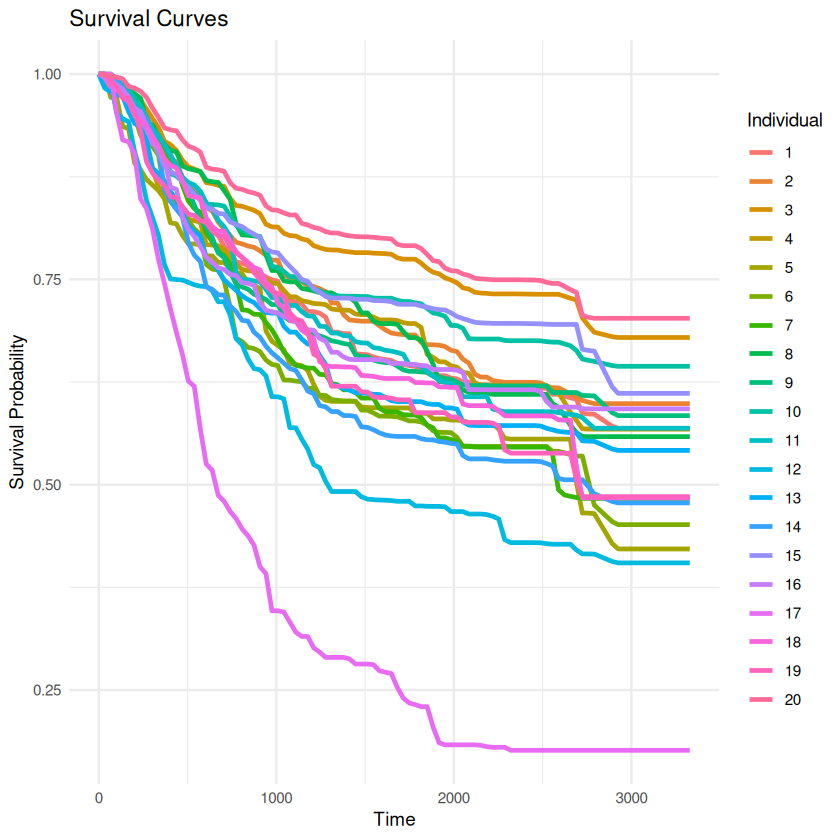

In [7]:
# Define patients to visualize
patient.list <- 1:20

# Define a time grid for evaluating survival probabilities
time.points <- seq(0, max(data.train$time), length.out = 100)

# Predict survival curves for selected patients
predictions <- surv_model$predict(data.test[patient.list, ], time.points)

# Plot predicted curves
#source("../csb/utils_plotting.R")  # Use plotting utility from CSB repo
plot_survival_curves(predictions)

## 📐 Build Conformal Survival Bands

Now that both the survival and censoring models are fitted, we can construct **conformal survival bands** using the `conformal_survival_band()` function from the `confsurv` package.

This method:

- Computes conformal p-values using IPC-weighted comparisons
- Applies Benjamini–Hochberg correction for multiple testing
- Returns **calibrated lower and upper bands** around the predicted survival curves

These bands offer predictive guarantees and are useful for screening tasks such as identifying low-risk or high-risk patients.

In [8]:
# Define a time grid for prediction and band construction
time.points <- seq(0, max(data.train$time), length.out = 100)

# Run conformal calibration procedure
csb <- conformal_survival_band(
    data.test = data.test,
    data.cal = data.cal,
    surv_model = surv_model,
    cens_model = cens_model,
    time_points = time.points,
    fast = TRUE
)

### Output of `calibrate_survival()`

The result is a list containing:

- `model_pred`: predicted survival probabilities from the fitted model
- `lower`, `upper`: calibrated lower and upper bands (pointwise)

Next, we’ll visualize these bands and explore how to use them for clinical-style risk screening.

### 📉 Comparison to Kaplan-Meier Survival Estimate

The Kaplan-Meier estimator is a classical nonparametric method for estimating the survival function from right-censored data.
We fit this model on the calibration dataset and use it as a baseline to compare against black-box model predictions and conformal survival bands.

This is especially useful for sanity checks, as the KM estimate does not use covariates and reflects the marginal survival distribution in the calibration set.

In [9]:
## Fit the Kaplan-Meier survival model on calibration data
surv_object <- Surv(time = data.cal$time, event = data.cal$status)
km_fit <- survival::survfit(surv_object ~ 1)

## Predict survival probabilities at pre-defined time grid
km_pred <- summary(km_fit, times = time.points, extend = TRUE)$surv

## Construct a matrix with identical KM survival curves for all test patients
## (each row corresponds to a patient, each column to a time point)
n_patients <- nrow(data.test)
km_pred <- matrix(rep(km_pred, each = n_patients), nrow = n_patients, byrow = FALSE)
colnames(km_pred) <- time.points

## 📈 Visualize Conformal Survival Bands for Individual Patients

We now plot conformal survival bands for a subset of patients. These bands are derived from the calibrated results and reflect uncertainty around the predicted survival probabilities.


The plot shows:

- The fitted survival curve (black line)
- The calibrated lower and upper bands (shaded region)
    

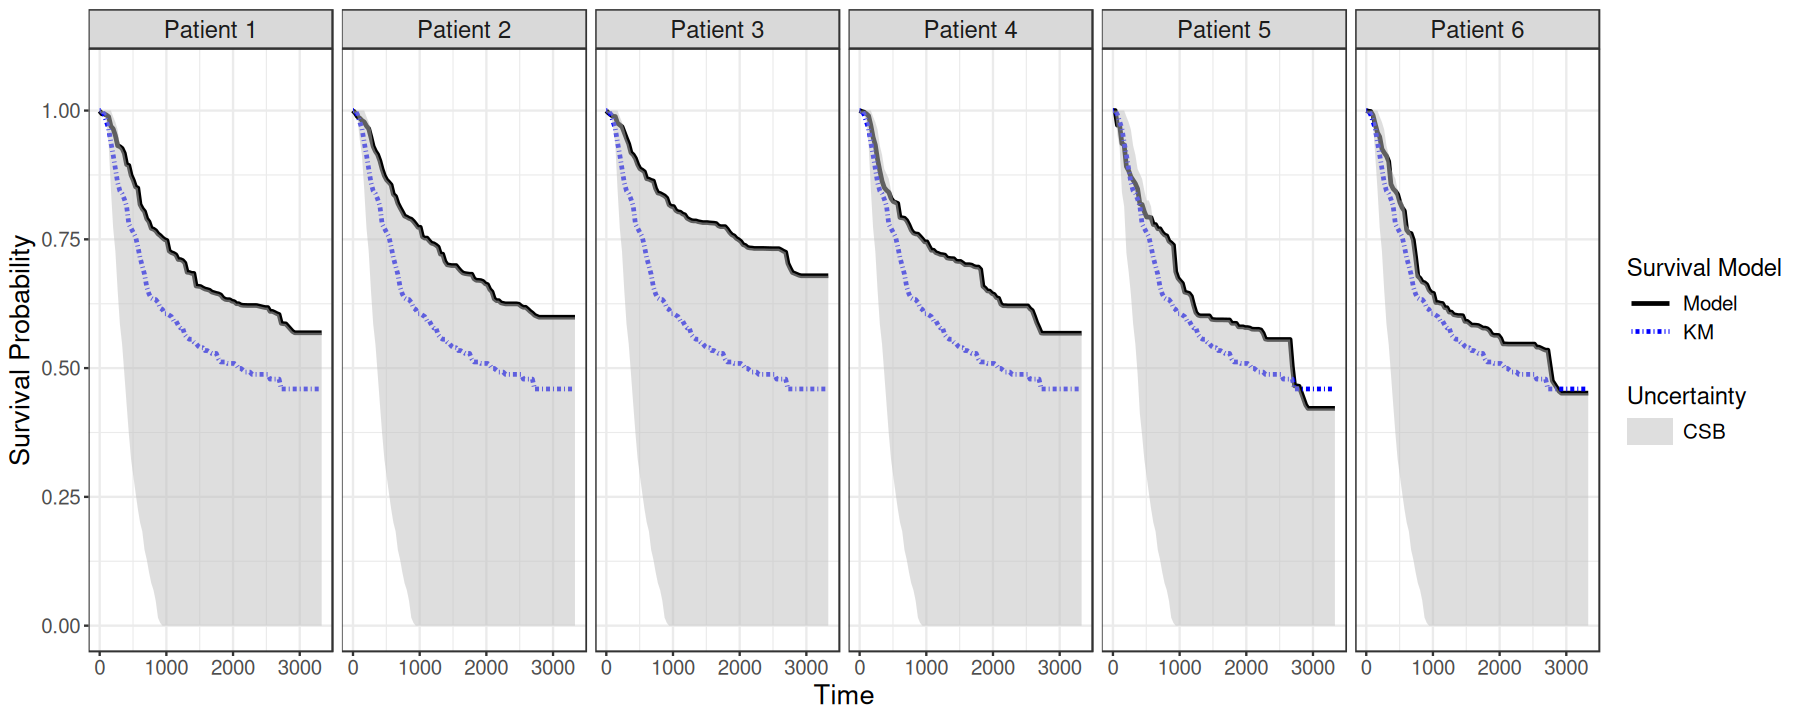

In [10]:
# Adjust plot dimensions for wide layout
options(repr.plot.width = 15, repr.plot.height = 6)

# Select patients to visualize
patient_ids <- 1:6

# Subset prediction matrices
pred_list <- list(
  "Model" = csb$model_pred[patient_ids, ],
  "KM" = km_pred[patient_ids, ]
)

# Subset band matrices (same patients)
band_list <- list(
  "CSB" = list(
    lower = csb$lower[patient_ids, ],
    upper = csb$upper[patient_ids, ]
  )
)

# Now safe to plot
plot_survival_panel(
  pred_list = pred_list,
  band_list = band_list,
  patient_names = paste("Patient",patient_ids)
)

## Screening Analysis Using Conformal Survival Bands

We now demonstrate how to use the conformal survival bands to **screen patients** based on a clinical decision rule.

For example, suppose a practitioner wants to identify **low-risk patients**—those with at least an 80% chance of surviving beyond 5 months. The conformal bands allow this kind of decision to be made with **predictive guarantees**.

We will:
- Define a screening threshold
- Visualize band-based decisions for selected patients
- Compare selections made by:
  - The raw survival model (no uncertainty)
  - Conformal survival bands

In [11]:
# Define screening parameters
screening_time <- 100         # Time threshold (e.g., 5 months)
screening_prob <- 0.8          # Survival probability threshold
screening_crit <- "low risk"   # Can also be "high risk"

# Display interpretation of the rule
cat(sprintf("Goal: Screening for %s.\n",
            interpret_screening_rule(screening_time, screening_prob, screening_crit)))

Goal: Screening for low-risk patients with P(survival at time 100.00) > 0.80.


### 📈 Visualize Screening Decisions for Individual Patients

We now visualize calibrated survival curves and screening selections using the `plot_survival_panel()` function. This plot compares multiple models and displays which patients are flagged under a chosen screening rule.

**Legend and Interpretation:**

- **Black line**: Fitted survival curve from the black-box model  
- **Gray shaded region**: Calibrated conformal survival band (doubly robust if enabled)  
- **Vertical line**: Screening time (e.g., 5 months)  
- **Horizontal line**: Screening threshold (e.g., 80% survival)  
- **Markers above the curves**:
  - **Black circle**: Patient flagged by the uncalibrated model
  - **Red triangle**: Patient flagged by the conformal band

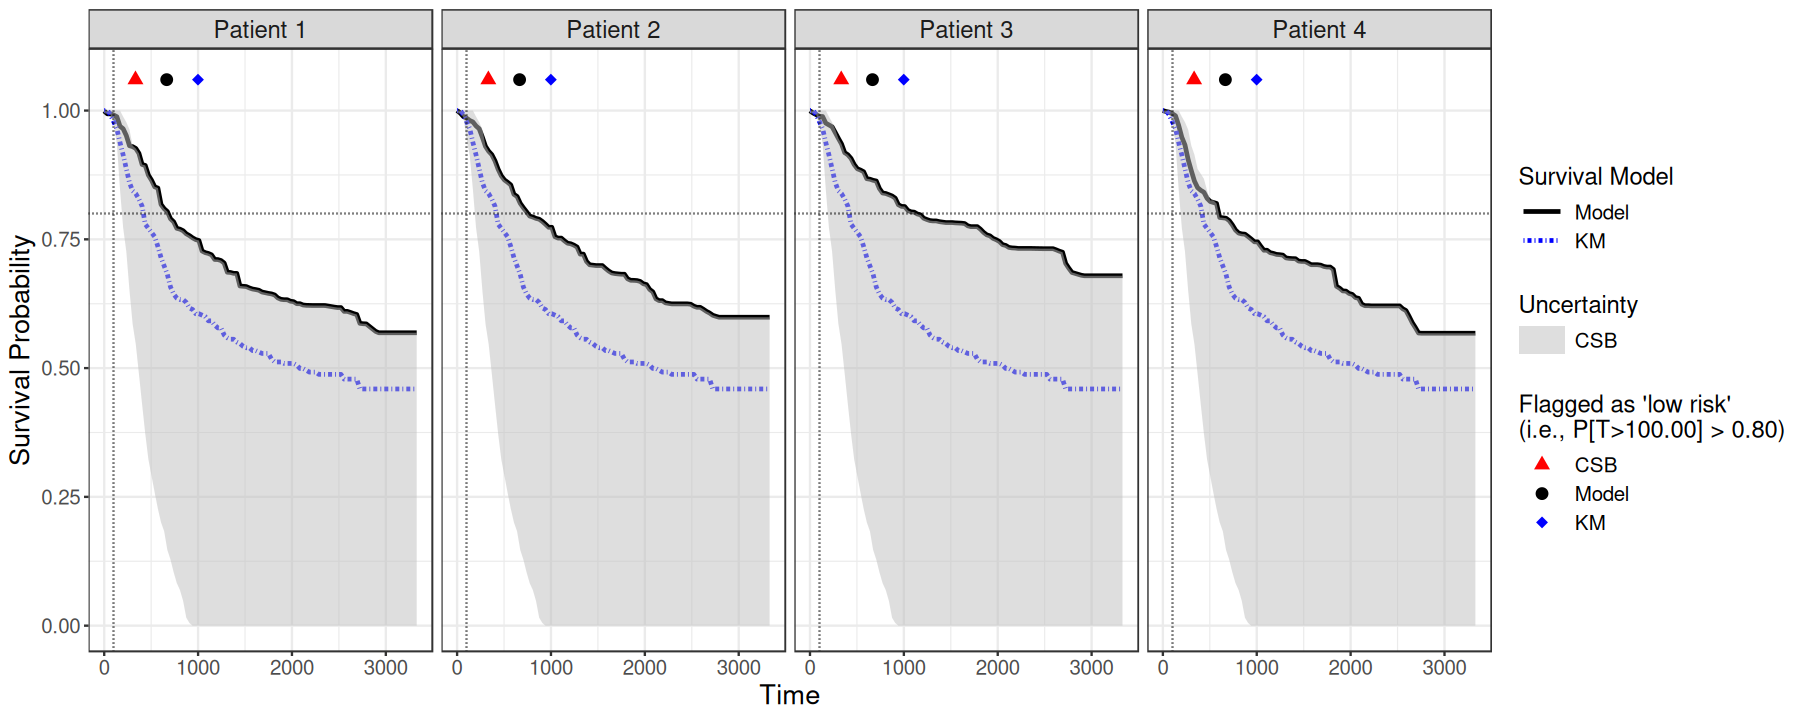

In [12]:
# Select patients
patient_ids <- 1:4

# Subset prediction matrices
pred_list <- list(
    "Model" = csb$model_pred[patient_ids, ],
    "KM" = km_pred[patient_ids, ]
)

# Subset band matrices (same patients)
band_list <- list(
  "CSB" = list(
    lower = csb$lower[patient_ids, ],
    upper = csb$upper[patient_ids, ]
  )
)

# Now safe to plot
plot_survival_panel(
  pred_list = pred_list,
  band_list = band_list,
  screening_time = screening_time,
  screening_prob = screening_prob,
  screening_crit = screening_crit,
  patient_names = paste("Patient",patient_ids)
)

### ✅ Evaluate Screening Accuracy Across Methods (Real Data)

We now compare different patient screening strategies under a user-defined decision rule:

- **Model**: Uses the raw survival probabilities from the black-box model  
- **CSB**: Uses the calibrated conformal survival band  
- **KM**: Uses the Kaplan-Meier estimate as a population-level baseline  

Since ground truth survival times are not available due to right-censoring, we evaluate each method based on:

- The number of patients it flags (as high- or low-risk)  
- The estimated range of survival probabilities among flagged patients, derived from the censored test data.

In [13]:
# Extract calibration results
time.points <- as.numeric(colnames(csb$model_pred))

# Apply the screening rule under different methods
sel_model <- select_patients_point(time.points, csb$model_pred, screening_time, screening_prob, screening_crit)$selected
sel_conf  <- select_patients_band(time.points, csb$lower, csb$upper, screening_time, screening_prob, screening_crit)$selected
sel_km    <- select_patients_point(time.points, km_pred, screening_time, screening_prob, screening_crit)$selected

# Combine selections
selections <- list(
  "model" = sel_model,
  "CSB"   = sel_conf,
  "KM"    = sel_km
)

## Evaluate and format results
evaluated <- map2_dfr(selections, names(selections), function(selected, method_name) {           
    res.raw <- evaluate_selections_without_oracle(data.test, selected, screening_time, screening_prob, screening_crit)
    res.raw %>%
        transmute(
            Method = method_name,
            Time = Screening.time,
            Criterion = screening_crit,
            Probability = screening_prob,
            Screened = Screened,
            Survival_lower = Proportion.survived.lower,
            Survival_upper = Proportion.survived.upper
        )
})
evaluated

Method,Time,Criterion,Probability,Screened,Survival_lower,Survival_upper
<chr>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<dbl>
model,100,low risk,0.8,371,0.9676550,0.9730458
CSB,100,low risk,0.8,370,0.9675676,0.9729730
KM,100,low risk,0.8,371,0.9676550,0.9730458


## Using Custom Survival Models

The conformal survival band framework is designed to be **model-agnostic**, so long as the survival model exposes a consistent interface. To integrate a custom model, you need to wrap it in an `R6` class (or a plain list) that implements the following methods.

### Required Methods for a Wrapper Class

Each model should subclass the abstract `SurvivalModelWrapper` and implement:

- `fit(formula, data)`: Train the model using right-censored data
- `predict(new_data, time.points)`: Return a list with:
  - `predictions`: A matrix of survival probabilities (rows = patients, cols = time points)
  - `time.points`: Vector of time values corresponding to the columns

---

### 📦 Example: Custom Wrapper for Generalized Random Forests

This example shows how to build a lightweight, functional wrapper around a Generalized Random Forest (GRF) survival model using a plain R list.

This wrapper supports the required `fit()` and `predict()` functions, making it compatible with the confsurv conformal band framework.

In [14]:
# Minimal GRF survival model wrapper using plain list and closure
GRFWrapperMinimal <- local({
  model <- NULL
  failure_times <- NULL

  list(
    fit = function(data) {
      X <- as.matrix(data[, setdiff(names(data), c("time", "status"))])
      Y <- data$time
      D <- data$status

      model <<- grf::survival_forest(X, Y = Y, D = D, num.trees = 100)
      failure_times <<- model$failure.times
    },

    predict = function(new_data, time.points = NULL) {
      if (is.null(time.points)) {
        time.points <- failure_times
      }

      X_new <- as.matrix(new_data[, setdiff(names(new_data), c("time", "status"))])
      pred <- predict(model, newdata = X_new)

      # Interpolate if custom time points are requested
      survival_probs <- pred$predictions
      if (!all(time.points %in% failure_times)) {
        survival_probs <- t(apply(survival_probs, 1, function(p) {
          approx(failure_times, p, xout = time.points, rule = 2)$y
        }))
      }

      list(predictions = survival_probs, time.points = time.points)
    }
  )
})

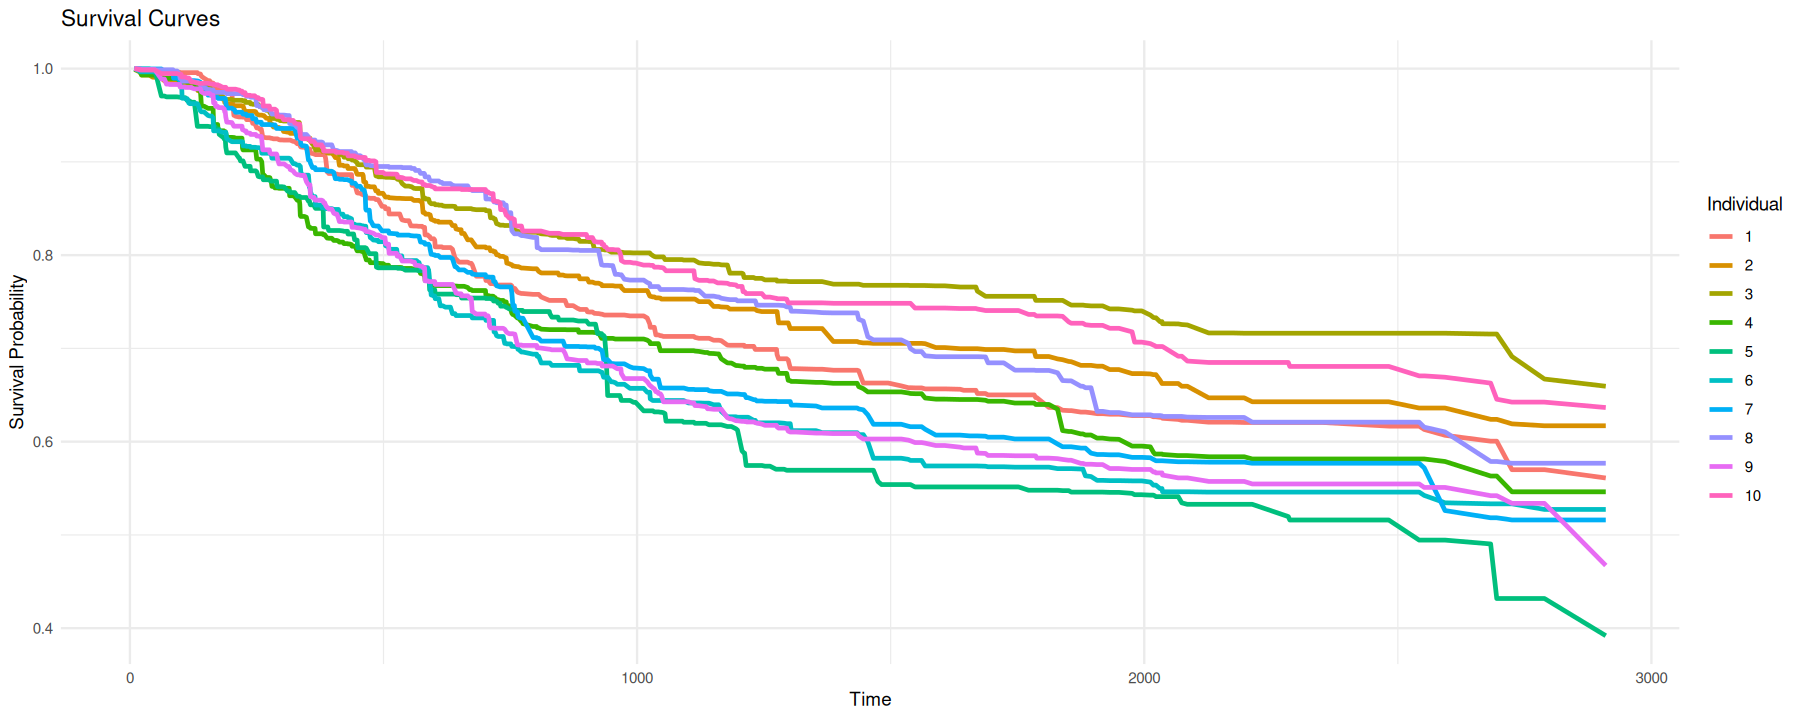

In [15]:
# Initialize the GRF model wrapper
grf_model <- GRFWrapperMinimal

# Fit the model on training data
grf_model$fit(data.train)

# Predict survival curves for test data at a custom time grid
grf_preds <- grf_model$predict(data.test)

# Plot for first 10 patients patients
grf_preds_first10 <- grf_model$predict(data.test[1:10,])
plot_survival_curves(grf_preds_first10)

### Build Conformal Survival Bands Using the Custom Model


In [16]:
time.points <- seq(0, max(data.train$time), length.out = 100)
csb_grf <- conformal_survival_band(
    data.test = data.test,
    data.cal = data.cal,
    surv_model = grf_model,
    cens_model = cens_model,
    time_points = time.points,
    fast = TRUE
)

### Visualize the Conformal Bands

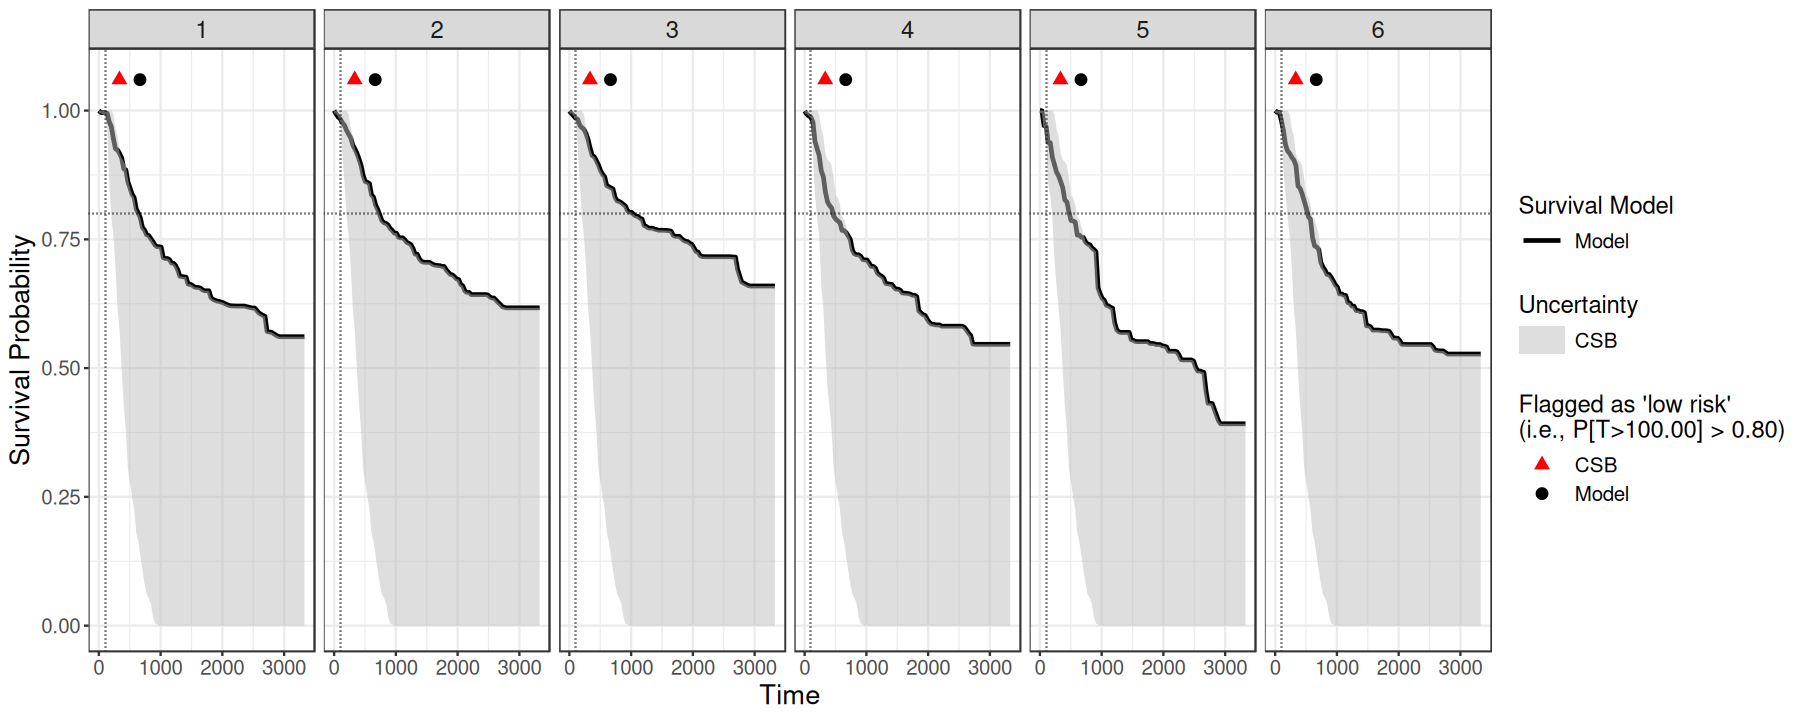

In [17]:
# Pick 6 patients
patient_ids <- 1:6

pred_list <- list("Model" = csb_grf$model_pred[patient_ids, ])
band_list <- list("CSB" = list(
    lower = csb_grf$lower[patient_ids, ],
    upper = csb_grf$upper[patient_ids, ]
))

plot_survival_panel(
  pred_list = pred_list,
  band_list = band_list,
  screening_time = 100,
  screening_prob = 0.8,
  screening_crit = "low risk",
  patient_names = patient_ids
)

### ✅ Evaluate Screening Accuracy Across Methods (Real Data)

We now compare different patient screening strategies under a user-defined decision rule:

- **Model**: Uses the raw survival probabilities from the black-box model  
- **CSB**: Uses the calibrated conformal survival band  
- **KM**: Uses the Kaplan-Meier estimate as a population-level baseline  

Since ground truth survival times are not available due to right-censoring, we evaluate each method based on:

- The number of patients it flags (as high- or low-risk)  
- The estimated range of survival probabilities among flagged patients, derived from the censored test data.

In [18]:
# Extract calibration results
time.points <- as.numeric(colnames(csb_grf$model_pred))

# Apply the screening rule under different methods
sel_model <- select_patients_point(time.points, csb_grf$model_pred, screening_time, screening_prob, screening_crit)$selected
sel_conf  <- select_patients_band(time.points, csb_grf$lower, csb_grf$upper, screening_time, screening_prob, screening_crit)$selected
sel_km    <- select_patients_point(time.points, km_pred, screening_time, screening_prob, screening_crit)$selected

# Combine selections
selections <- list(
  "model" = sel_model,
  "CSB"   = sel_conf,
  "KM"    = sel_km
)

## Evaluate and format results
evaluated <- map2_dfr(selections, names(selections), function(selected, method_name) {           
    res.raw <- evaluate_selections_without_oracle(data.test, selected, screening_time, screening_prob, screening_crit)
    res.raw %>%
        transmute(
            Method = method_name,
            Time = Screening.time,
            Criterion = screening_crit,
            Probability = screening_prob,
            Screened = Screened,
            Survival_lower = Proportion.survived.lower,
            Survival_upper = Proportion.survived.upper
        )
})
evaluated

Method,Time,Criterion,Probability,Screened,Survival_lower,Survival_upper
<chr>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<dbl>
model,100,low risk,0.8,371,0.9676550,0.9730458
CSB,100,low risk,0.8,370,0.9702703,0.9756757
KM,100,low risk,0.8,371,0.9676550,0.9730458
